<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/Lec_6/NN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from matplotlib import style
plt.style.use('seaborn-talk')

import warnings
warnings.filterwarnings('ignore')

# Basic utility functions 

In [3]:
'''
Define different loss functions. 
'''
def_noise = 10e-6
def cross_entropy(y, a, noise = def_noise):
#     print(y)
#     print(a)
    if y.shape == a.shape:
        y_in = y.reshape(-1)
        a_in = a.reshape(-1)
        n_s = len(y_in )

        return (-np.dot( y_in, np.log(a_in + noise  ).T )/n_s - 
                np.dot((1-y_in),np.log( (1-a_in) + noise  ).T )  )/n_s#.reshape(y)  
    else:
        print('The shape of target and predicted arrays do not match. ')
        print(y.shape)
        print(a.shape)
        
def d_cross_entropy(y,a, noise = def_noise):
    return ( -y/(a + noise) + (1-y)/(1-a + noise)  )



def l2_loss(y, a):
    return np.mean( (y-a)**2 )/2

def d_l2_loss(y, a):
    return ( -(y-a) )

In [4]:
'''
For fast evaluation of the derivatives, it's best to precompute the derivatives of the activation functions. 
'''

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    a = sigmoid(x) #1 / (1 + np.exp(-x))
    return a*(1-a) 


def relu(x):
    return np.maximum(0,x)

## Input cannot be a list, it has to be either a number or a numpy array. 
def d_relu(x):
    return x>0

def leaky_relu(x):
    return np.maximum(0.01*x ,x)

## Input cannot be a list, it has to be either a number or a numpy array. 
def d_leaky_relu(x):
    return (x>0) + .01*(x<0)


def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1-np.tanh(x)**2



In [5]:
'''
This will make a random network based on the nodes in each layer.
The inputs are
nl_list = [n_f, n_l1, n_l2, ..., n_c]: with n_li the number of nodes in layer i. 

We could add 
activation_func_list = [act_func_1, act_func_2, ... ]
But for now, we keep it simple. 

'''

def random_network_generator( nl_list ):
    w_list = []
    b_list = []
    for i in range(len(nl_list)-1 ):
        w_list += [ np.random.uniform(-1,1,size=[nl_list[i+1] , nl_list[i] ]) ]
        b_list += [ np.random.uniform(-1,1,size=[ nl_list[i+1], 1 ]) ]
    return w_list, b_list

In [0]:
def grid(x1, x2, off_set = .1, n_points = 100):
    ## d s show the range in the two varible. 
    d1 = x1.max() - x1.min()
    d2 = x2.max() - x2.min()
    
    x1_min, x1_max = x1.min() - off_set * d1 , x1.max() + off_set * d1
    x2_min, x2_max = x2.min() - off_set * d2 , x2.max() + off_set * d2

    ## This function from numpy gives a list of coordinates that are the points on the grid. 
    x, y = np.meshgrid(np.arange(x1_min, x1_max , d1/n_points), np.arange(x2_min, x2_max , d2/n_points) )

    return x , y 

# Implement your own code for NN

Now we want to do this ourselves, not using the optimizer. 

We will use a simple GD algorithm which basically does the following:

w_1  -> w_1 - alpha * dL/dw_1

w_2  -> w_2 - alpha * dL/dw_2

## NN Implementation

In [62]:
### V2: Including the Activation functions and loss 

'''
X.shape => (n_f, n_s)
Y.shape => (1, n_s)
'''
class NN():
    
    def __init__(self, nl_list, 
                 ## The activation_func _list should be of shape (n_layers-1, 2)
                 ## This is b/c we need both the func and its derivative. 
                 activation_func_list= [[ lambda x: sigmoid(x), lambda x:sigmoid(x)*(1-sigmoid(x)) ] ], 
                 loss = [cross_entropy, d_cross_entropy],
                 n_itr = 1000, ETA = .01, return_hist = False, 
                 return_loss_hist = False):

        self.trained_ = False  # This is to indicate if the model is trained already.'''
        
        self.n_f = nl_list[0]   #The number of input features. '''
        self.n_l_list = nl_list
        self.n_layers = len(nl_list)
        print(f"There are {self.n_layers} layers in this network.")
               
        self.w_list_, self.b_list_ = random_network_generator(self.n_l_list)
        
        self.loss_func = loss
        if not len(activation_func_list) == self.n_layers-1:
            print('Not enough act_func, will use the first layer for all of them.')
#             print
            self.activation_func_list = np.array([activation_func_list[0] for i in range(self.n_layers-1) ])
#             print(self.activation_func_list.shape)
        else:
#             print(self.n_layers-2)
            self.activation_func_list = np.array(activation_func_list)
#             print(self.activation_func_list[self.n_layers-2][1](2)   )
        
#         self.noise = noise
        self.ETA = ETA    #The learning rate.'''
        self.n_itr = n_itr   #The number of iterations.'''
        
        self.return_hist = return_hist   #Indicates if the user wants history of the w and b.'''
        self.return_loss = return_loss_hist  #Indicates if the user wants history of the loss.'''
        
        self.a_list = []
        self.z_list = []
        
        self.loss_hist = []
        self.w_hist = []
        self.b_hist = []
        
        
    '''
    This takes the inputs of the NN or the output of the
    proceeding layer and take it one layer further. 
    
    The input shapes are
    x: (n_(l-1), n_s)
    w_list: {w_l :  ( n_(l), n_(l-1) ) }
    b_list: {b_l :  ( n_(l), 1 ) }
    '''
    def single_step_forward(self, x, w, b ,  activation_func): #=(lambda x: sigmoid(x)  ) ):
#         print(activation_func)
        z = np.dot( w, x) + b
        return z , activation_func( z )  #For now, we keep both z and a. '''


    '''
    We now define our general neural network function. 

    The input shapes are
    x: (n_f, n_s)
    w_list: {w_l :  ( n_(l), n_(l-1) ) }
    b_list: {b_l :  ( n_(l), 1 ) }

    We return both z and a in all the layers for the output. 
    This could be too much for a real data!!

    '''
        
    def predict(self, X):
        if self.trained_:  #Only returns a value if the model is already trained. '''
            a = X
            
            self.z_list = []
            self.a_list = [a]
            if len(self.activation_func_list) == 1:  ##Apply the same function to all layers if there is a single act_func.
                for i in range(len(self.w_list_)):
                                        
                    z, a = self.single_step_forward( x=self.a_list[-1], 
                                                    w = self.w_list_[i], 
                                                    b=self.b_list_[i],
                                                   activation_func = self.activation_func_list[0, 0])
                    self.z_list += [ z ]
                    self.a_list += [ a ]
                    
            else:                              ##Apply a differnt function to each layer.
                for i in range(len(self.w_list_)):
#                     print(i)
                    z, a = self.single_step_forward(a , self.w_list_[i], 
                                                    self.b_list_[i] , 
                                                    self.activation_func_list[i][0] )
                    self.z_list += [ z ]
                    self.a_list += [ a ]

#             print(a)
            return a

        else:
            print("Not trained yet. ")

            
    def score(self, X_test, Y_test):  ## This works only if this is a classifier. 
        y_predict = self.predict(X_test).reshape(-1) >0.5
        n_s = len(y_predict)
        return np.sum(y_predict==(Y_test.reshape(-1)>.5) )/n_s

    
    def fit(self, X,Y):
        
        #----------------Initialization
        self.trained_= True  #Indicates that the model is trained. It doesnt have to be perfect. '''
        self.n_f , n_s = X.shape        
        loss_list = []
        w_list_list = []
        b_list_list = []

        #----------------Loop over the following for as many interations
        for m in range(self.n_itr):

            #----------------Feedforward        
            layer_ind = self.n_layers - 1  ## We start from zero.
            a = self.predict( X )
#             print(f'You are in itr. {m} and back to layer {layer_ind}')
#             print(a)

            #----------------Book-keeping
#             print(Y.shape)
#             print(a.shape)
            loss_list += [ self.loss_func[0](Y, a) ]
            w_list_list += [self.w_list_.copy()]
            b_list_list += [self.b_list_.copy()]
#             print(layer_ind, len(self.activation_func_list[layer_ind-1]))
#             print( self.activation_func_list[layer_ind-1 , 1] )
            ## Backprop
            #----------------Back-prop for the output layer
            da = self.loss_func[1](Y, a)
#             print(a.shape)
#             print(Y.shape)
#             da = (-Y/(a+def_noise) +(1-Y)/((1-a)+ def_noise )  )   #==> This is specific to CE loss function. 
#             dz = da* ( a*(1-a) )      #==> This is for sigmoid at the output layer. Has to change. 
            dz = da * self.activation_func_list[layer_ind-1 , 1](self.z_list[layer_ind-1]) 
#             print(layer_ind, len(self.z_list))
#             print(da, '\n')
            dw = np.dot(  dz, self.a_list[layer_ind-1].T  ).reshape(self.n_l_list[layer_ind], 
                                                                    self.n_l_list[layer_ind-1])/n_s
            db = np.sum(dz, axis=1).reshape(self.n_l_list[layer_ind],1)/n_s
#             print( f'For layer {layer_ind}, the shape of dw is { dw.shape}.')
            dw_list = [dw]
            db_list = [db]
            #----------------Back-prop to the begining of the network
            for i in range(1, len(self.n_l_list)-1):
                layer_ind =  self.n_layers-i-1
                a = self.a_list[layer_ind]
                w = self.w_list_[layer_ind]

                #----------------Back-prop for the output layer
                dz = np.dot( w.T, dz ) * self.activation_func_list[layer_ind-1 , 1](self.z_list[layer_ind-1])     
                        #==> This is for sigmoid at the output layer. Has to change. 
#                 print(w[0], '\n')
                dw = np.dot(  dz, self.a_list[layer_ind-1].T  ).reshape(self.n_l_list[layer_ind], 
                                                                        self.n_l_list[layer_ind-1])/n_s
                db = np.sum(dz, axis=1).reshape(self.n_l_list[layer_ind],1)/n_s
#                 print( f'For layer {layer_ind}, the shape of dw is { self.activation_func_list[layer_ind][1] }.')

                #----------------Add to the list of the parameters derivatives. 
                dw_list += [dw]
                db_list += [db]
            

            #-----------------------Update the parameters. 
            dw_list = dw_list[::-1]
            db_list = db_list[::-1]
            self.w_list_ = [self.w_list_[ind] - self.ETA*dw_list[ind] for ind in range(self.n_layers-1)]
            self.b_list_ = [self.b_list_[ind] - self.ETA*db_list[ind] for ind in range(self.n_layers-1)]
            
        
        #----------------Book-keeping
        a = self.predict( X )
#         print(Y.shape)
#         print(a.shape)
        loss_list += [self.loss_func[0](Y, a) ]
        w_list_list += [self.w_list_.copy()]
        b_list_list += [self.b_list_.copy()]
            
        self.loss_hist += loss_list
        self.w_hist += [w_list_list]
        self.b_hist += [b_list_list   ]

## Examples

The baseline is: -7.802160989311182e-06
There are 4 layers in this network.
Wall time: 1.2 s


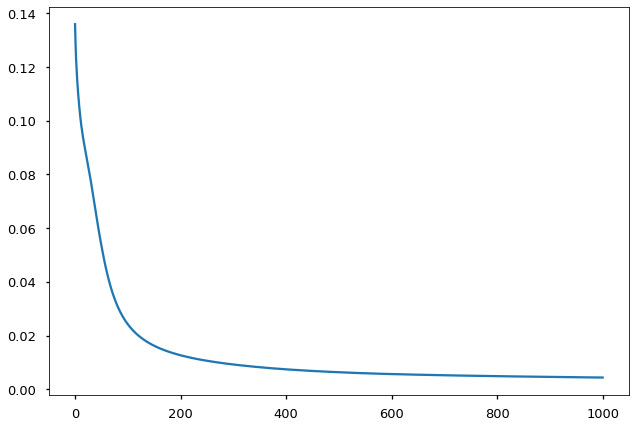

In [65]:
%%time 
x = np.random.uniform(-1, 1, size = [2, 1000])
test = x[0]**2+6*x[1] - 3
test = (test>.5).astype(int).reshape(1,-1)
print('The baseline is:', cross_entropy(test, test))

nl_list = [2,7,6, 1]
act_list = [ [relu, d_relu] ,[relu, d_relu] , [sigmoid, d_sigmoid] ]
loss_fn = [l2_loss, d_l2_loss]
model = NN(nl_list, n_itr=1000, ETA = .5, activation_func_list=act_list, loss=loss_fn)
model.fit(x, test)
plt.plot(model.loss_hist)

(2, 50, 50)


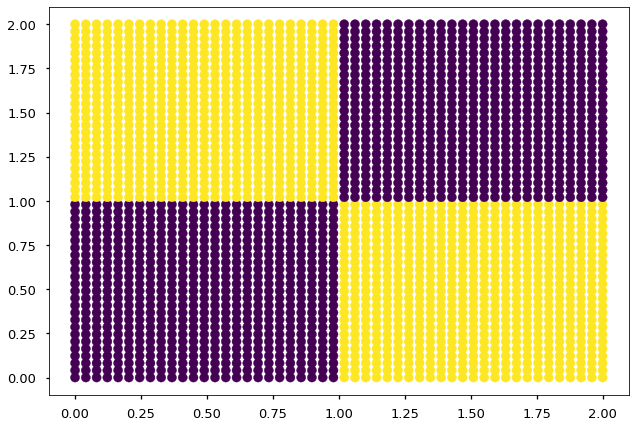

In [46]:
'''
Let's make an example and see how this works.
'''
x1 = np.linspace(0,2)
x1, x2 = np.meshgrid(x1, x1)
X = np.array([x1, x2])
print(X.shape)

def Charkhoune(x):
    return np.logical_xor(x[0]>1 , x[1]>1)

Y = Charkhoune(X).astype(int)
plt.scatter(X[0], X[1], c = Y)
plt.show()

There are 4 layers in this network.


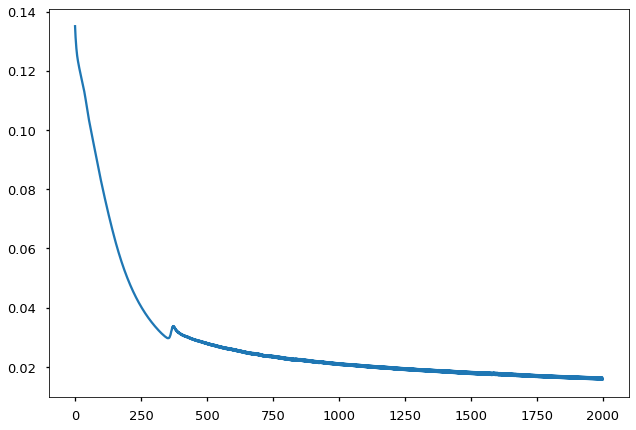

In [68]:
nl_list = [2,7,6, 1]
act_list = [ [relu, d_relu] ,[relu, d_relu] , [sigmoid, d_sigmoid] ]
loss_fn = [l2_loss, d_l2_loss]

model = NN(nl_list, n_itr=2000, ETA = .5, activation_func_list=act_list, loss=loss_fn)
model.fit(X.reshape(2,-1), Y.reshape(1,-1))
plt.plot(model.loss_hist)
plt.show()

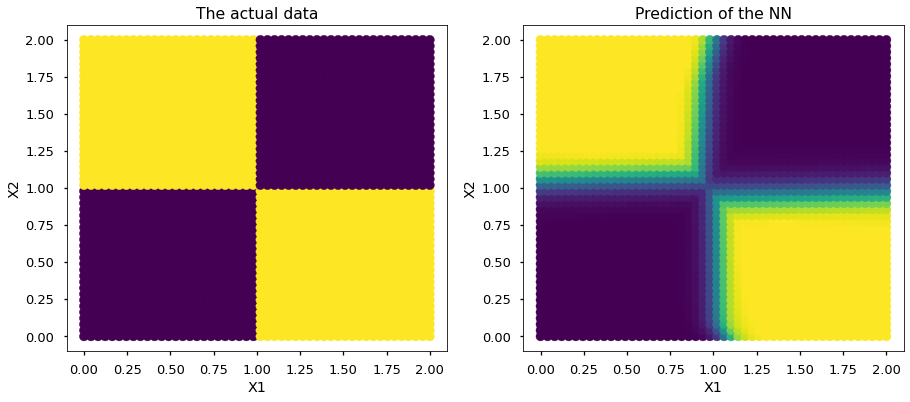

In [69]:
y_pred = model.predict(X.reshape(2,-1)).reshape(x1.shape)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, xlabel='X1', ylabel='X2', title='The actual data')
plt.scatter(X[0], X[1], c = Y)

ax = fig.add_subplot(122, xlabel='X1', ylabel='X2', title='Prediction of the NN')
plt.scatter(X[0], X[1], c = y_pred)

plt.show()
plt.close()

### Visualization of the Dynamics

In [0]:
y_pred_list = []
for i in np.arange(0, len(model.w_hist), 100):
    y_pred_list += [NN_forward(X.reshape(2,-1), model.w_hist[i], model.b_hist[i] )]
    
y_pred_list = np.array( y_pred_list ).reshape(-1, 2500)>.5



In [0]:
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, fixed, IntSlider

def wig_fock_state(n):
    plt.scatter(X[0].reshape(-1), X[1].reshape(-1), c=i, s=100)
    plt.show()
    
    

ImportError: cannot import name 'RadioWidget'

## Example 2

In [6]:
# import requests, io
# url = 'https://raw.githubusercontent.com/sraeisi/Machine_Learning_Physics_Winter20/master/Lec1/particle_mini.npz'
# s=requests.get(url, stream=True).content
# data=np.load(io.BytesIO(s) )

data = np.load( 'particle_mini.npz' )
X, Y = data['X'], data['Y']
# The labels are 1 or 2. So we need to turn them into 0 and  1. 
Y = (Y>1.5).astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, random_state= 0)


There are 3 layers in this network.


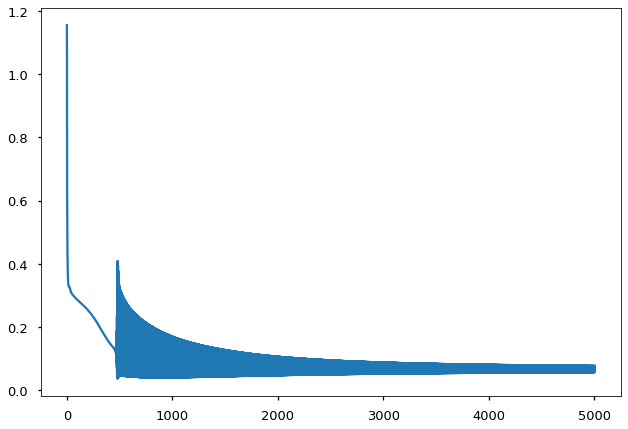

CPU times: user 11.7 s, sys: 8.3 s, total: 20 s
Wall time: 10.2 s


In [0]:
%%time
nl_list = [2, 4 , 1]
# act_list = [[sigmoid, d_sigmoid] , [sigmoid, d_sigmoid] , [sigmoid, d_sigmoid] ]
act_list = [ [relu, d_relu] , [sigmoid, d_sigmoid] ]

model = NN(nl_list, n_itr=5000, ETA = .2, activation_func_list=act_list)
# model.ETA = .1
# model.n_itr= 1000
model.fit(X_train.T, Y_train.reshape(1,-1))
plt.plot(model.loss_hist)
plt.show()

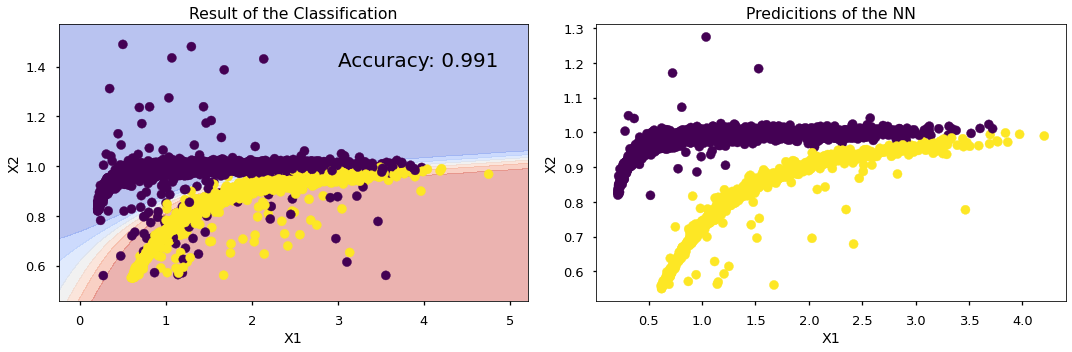

In [0]:
#predictions of the model for test set
y_predict = (model.predict(X_test.T)>.5).astype(int)

x1_list, x2_list = grid(X[:,0], X[:,1], n_points=70)
X_grid = np.vstack([x1_list.reshape(-1),x2_list.reshape(-1)]).T
Y_grid = model.predict( X_grid.T ).reshape(x1_list.shape )

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121 , xlabel = 'X1', ylabel='X2', title = 'Result of the Classification')
    
ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)
ax.scatter(*X.T, c=Y)    
ax.text(3, 1.4, f'Accuracy: {np.round( model.score(X_test.T, Y_test) , 3)}' , fontsize=20)

ax = fig.add_subplot(122 , xlabel = 'X1', ylabel='X2', title = 'Predicitions of the NN')
plt.scatter(*X_test.T, c = y_predict.reshape(-1))


plt.tight_layout()
plt.show()

# Optimization of the training

## GPU

***Question*** Convert all of the arrays in your implementation to pytorch tensor and put them on the GPU device. 
Compare the speed of the training between the two. 

***Question*** Redo your code and use the backward method of the variables in pytorch to calculate instead of the manual calculation. 

## Mini-batch Optimization

In [92]:
n_epc = 3
b_s = 1000
tn_s = len(X_train)
    
for i in range(n_epc* int( tn_s/b_s  ) ):
    X_btch, Y_btch = X[ b_s*i%tn_s: b_s*(i+1)%tn_s], Y[ b_s*i%tn_s: b_s*(i+1)%tn_s]
    print(X_btch.shape)
    print(Y_btch.shape)
    print(f'Goes from { b_s*i%tn_s} to {b_s*(i+1)%tn_s}.\n' )

(1000, 2)
(1,)
Goes from 0 to 1000.

(1000, 2)
(1,)
Goes from 1000 to 2000.

(1000, 2)
(1,)
Goes from 2000 to 3000.

(1000, 2)
(1,)
Goes from 3000 to 4000.

(1000, 2)
(1,)
Goes from 4000 to 5000.

(1000, 2)
(1,)
Goes from 5000 to 6000.

(1000, 2)
(1,)
Goes from 6000 to 7000.

(0, 2)
(1,)
Goes from 7000 to 858.

(1000, 2)
(1,)
Goes from 858 to 1858.

(1000, 2)
(1,)
Goes from 1858 to 2858.

(1000, 2)
(1,)
Goes from 2858 to 3858.

(1000, 2)
(1,)
Goes from 3858 to 4858.

(1000, 2)
(1,)
Goes from 4858 to 5858.

(1000, 2)
(1,)
Goes from 5858 to 6858.

(0, 2)
(1,)
Goes from 6858 to 716.

(1000, 2)
(1,)
Goes from 716 to 1716.

(1000, 2)
(1,)
Goes from 1716 to 2716.

(1000, 2)
(1,)
Goes from 2716 to 3716.

(1000, 2)
(1,)
Goes from 3716 to 4716.

(1000, 2)
(1,)
Goes from 4716 to 5716.

(1000, 2)
(1,)
Goes from 5716 to 6716.



In [6]:
### V3: Including mini-batch optimization

'''
X.shape => (n_f, n_s)
Y.shape => (1, n_s)
'''
class NN():
    
    def __init__(self, nl_list, 
                 ## The activation_func _list should be of shape (n_layers-1, 2)
                 ## This is b/c we need both the func and its derivative. 
                 activation_func_list= [[ lambda x: sigmoid(x), lambda x:sigmoid(x)*(1-sigmoid(x)) ] ], 
                 loss = [cross_entropy, d_cross_entropy],
                 n_epoch = 10, ETA = .01, 
                 batch_size = 4,
                 return_hist = False, 
                 return_loss_hist = False):

        self.trained_ = False  # This is to indicate if the model is trained already.'''
        
        self.n_f = nl_list[0]   #The number of input features. '''
        self.n_l_list = nl_list
        self.n_layers = len(nl_list)
        print(f"There are {self.n_layers} layers in this network.")
               
        self.w_list_, self.b_list_ = random_network_generator(self.n_l_list)
        
        self.loss_func = loss
        if not len(activation_func_list) == self.n_layers-1:
            print('Not enough act_func, will use the first layer for all of them.')
            self.activation_func_list = np.array([activation_func_list[0] for i in range(self.n_layers-1) ])
        else:
            self.activation_func_list = np.array(activation_func_list)
        
        self.ETA = ETA    #The learning rate.'''
        self.batch_size = batch_size
        self.n_epoch = n_epoch   #The number of iterations.'''
        
        self.return_hist = return_hist   #Indicates if the user wants history of the w and b.'''
        self.return_loss = return_loss_hist  #Indicates if the user wants history of the loss.'''
        
        self.a_list = []
        self.z_list = []
        
        self.loss_hist = []
        self.w_hist = []
        self.b_hist = []
        
        
    '''
    This takes the inputs of the NN or the output of the
    proceeding layer and take it one layer further. 
    
    The input shapes are
    x: (n_(l-1), n_s)
    w_list: {w_l :  ( n_(l), n_(l-1) ) }
    b_list: {b_l :  ( n_(l), 1 ) }
    '''
    def single_step_forward(self, x, w, b ,  activation_func): 
        z = np.dot( w, x) + b
        return z , activation_func( z )  


    '''
    We now define our general neural network function. 

    The input shapes are
    x: (n_f, n_s)
    w_list: {w_l :  ( n_(l), n_(l-1) ) }
    b_list: {b_l :  ( n_(l), 1 ) }

    We return both z and a in all the layers for the output. 
    This could be too much for a real data!!

    '''
        
    def predict(self, X):
        if self.trained_:  #Only returns a value if the model is already trained. '''
            a = X
            
            self.z_list = []
            self.a_list = [a]
            if len(self.activation_func_list) == 1:  ##Apply the same function to all layers if there is a single act_func.
                for i in range(len(self.w_list_)):
                                        
                    z, a = self.single_step_forward( x=self.a_list[-1], 
                                                    w = self.w_list_[i], 
                                                    b=self.b_list_[i],
                                                   activation_func = self.activation_func_list[0, 0])
                    self.z_list += [ z ]
                    self.a_list += [ a ]
                    
            else:                              ##Apply a differnt function to each layer.
                for i in range(len(self.w_list_)):
                    z, a = self.single_step_forward(a , self.w_list_[i], 
                                                    self.b_list_[i] , 
                                                    self.activation_func_list[i][0] )
                    self.z_list += [ z ]
                    self.a_list += [ a ]

            return a

        else:
            print("Not trained yet. ")

            
    def score(self, X_test, Y_test):  ## This works only if this is a classifier. 
        y_predict = self.predict(X_test).reshape(-1) >0.5
        n_s = len(y_predict)
        return np.sum(y_predict==(Y_test.reshape(-1)>.5) )/n_s

    
    def fit(self, X,Y):
        
        #----------------Initialization
        self.trained_= True  #Indicates that the model is trained. It doesnt have to be perfect. '''
        self.n_f , n_s = X.shape        
        loss_list = []
        w_list_list = []
        b_list_list = []

        #----------------Loop over the following for as many interations
#         for m in range(self.n_epoch):
        for m in range(self.n_epoch* int( n_s / self.batch_size  ) ):
            batch_ind_i, batch_ind_f = self.batch_size * m%n_s , self.batch_size * (m+1)%n_s
            if batch_ind_f > batch_ind_i:
                X_batch, Y_batch = X[:, batch_ind_i: batch_ind_f ], Y[:, batch_ind_i: batch_ind_f]
            else:
                X_batch, Y_batch = X[:, np.arange(batch_ind_i-n_s, batch_ind_f) ], Y[:, np.arange(batch_ind_i-n_s, batch_ind_f) ]
                
#             print(X_batch.shape)
#             print(Y_batch.shape)
#             if m%100==0:
#                 print(f'Iteration: {m}: Goes from { batch_ind_i } to {batch_ind_f}.\n' )
            #----------------Feedforward        
            layer_ind = self.n_layers - 1  ## We start from zero.
            a = self.predict( X_batch )

            #----------------Book-keeping
            loss_list += [ self.loss_func[0](Y_batch, a) ]
            w_list_list += [self.w_list_.copy()]
            b_list_list += [self.b_list_.copy()]

            ## Backprop
            #----------------Back-prop for the output layer
            da = self.loss_func[1](Y_batch, a)
            dz = da * self.activation_func_list[layer_ind-1 , 1](self.z_list[layer_ind-1]) 

            dw = np.dot(  dz, self.a_list[layer_ind-1].T  ).reshape(self.n_l_list[layer_ind], 
                                                                    self.n_l_list[layer_ind-1])/n_s
            db = np.sum(dz, axis=1).reshape(self.n_l_list[layer_ind],1)/n_s
            dw_list = [dw]
            db_list = [db]

            #----------------Back-prop to the begining of the network
            for i in range(1, len(self.n_l_list)-1):
                layer_ind =  self.n_layers-i-1
                a = self.a_list[layer_ind]
                w = self.w_list_[layer_ind]

                #----------------Back-prop for the output layer
                dz = np.dot( w.T, dz ) * self.activation_func_list[layer_ind-1 , 1](self.z_list[layer_ind-1])     
                dw = np.dot(  dz, self.a_list[layer_ind-1].T  ).reshape(self.n_l_list[layer_ind], 
                                                                        self.n_l_list[layer_ind-1])/n_s
                db = np.sum(dz, axis=1).reshape(self.n_l_list[layer_ind],1)/n_s

                #----------------Add to the list of the parameters derivatives. 
                dw_list += [dw]
                db_list += [db]
            

            #-----------------------Update the parameters. 
            dw_list = dw_list[::-1]
            db_list = db_list[::-1]
            self.w_list_ = [self.w_list_[ind] - self.ETA*dw_list[ind] for ind in range(self.n_layers-1)]
            self.b_list_ = [self.b_list_[ind] - self.ETA*db_list[ind] for ind in range(self.n_layers-1)]
            
        
        #----------------Book-keeping
        a = self.predict( X_batch )
        loss_list += [self.loss_func[0](Y_batch, a) ]
        w_list_list += [self.w_list_.copy()]
        b_list_list += [self.b_list_.copy()]
            
        self.loss_hist += loss_list
        self.w_hist += [w_list_list]
        self.b_hist += [b_list_list   ]

There are 3 layers in this network.


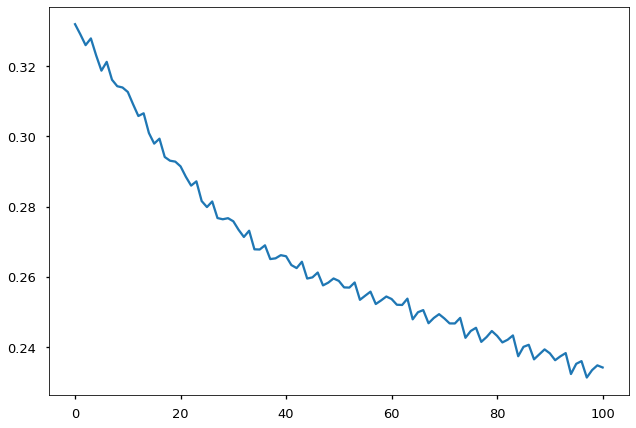

Wall time: 706 ms


In [24]:
%%time
nl_list = [2, 4 , 1]
# act_list = [[sigmoid, d_sigmoid] , [sigmoid, d_sigmoid] , [sigmoid, d_sigmoid] ]
act_list = [ [relu, d_relu] , [sigmoid, d_sigmoid] ]
loss_fn = [l2_loss, d_l2_loss]

model = NN(nl_list, n_epoch=100, batch_size=5000, ETA = .2, activation_func_list=act_list)
# model.ETA = .1
# model.n_itr= 1000
model.fit(X_train.T, Y_train.reshape(1,-1))
plt.plot(model.loss_hist)
plt.show()

***Question:*** Try different values of batch-size and 

- Compare the time for each epoch

- Plot the accuracy achieved in some unit of time (1 min) for different values of the batch-size. 

## Optimization Routine

***Quesion:*** Adopt your implemnetation of the NN to use momentum, rmsprop and adam